In [4]:
import pandas as pd

df = pd.read_csv('/content/option_SPY_dataset_combined.csv')
print(df.columns)
print(df.describe)
print(df.head)

Index(['14d', '30d', '3d', '5d', '60d', '7d', 'ask', 'bid', 'bs',
       'daysToExpiration', 'delta', 'dist', 'dist_pct', 'dt', 'expr',
       'extrinsic', 'extrinsic_pct', 'gamma', 'inTheMoney', 'intrinsic',
       'intrinsic_pct', 'iv', 'mark', 'openInterest', 'rho', 'strike',
       'theoreticalOptionValue', 'theoreticalVolatility', 'theta', 'timeValue',
       'underlying', 'vega', 'volatility', 'prev_iv'],
      dtype='object')
<bound method NDFrame.describe of              14d        30d         3d         5d        60d         7d  \
0      19.059668  21.521791  15.146374  16.748567  17.026154  15.778739   
1      19.059668  21.521791  15.146374  16.748567  17.026154  15.778739   
2      19.059668  21.521791  15.146374  16.748567  17.026154  15.778739   
3      19.059668  21.521791  15.146374  16.748567  17.026154  15.778739   
4      19.059668  21.521791  15.146374  16.748567  17.026154  15.778739   
...          ...        ...        ...        ...        ...        ...   
4481

Calibrated Parameters:
κ = 5.0000, θ = 1.0000, σ = 1.0000, ρ = -0.9900, v₀ = 0.0637


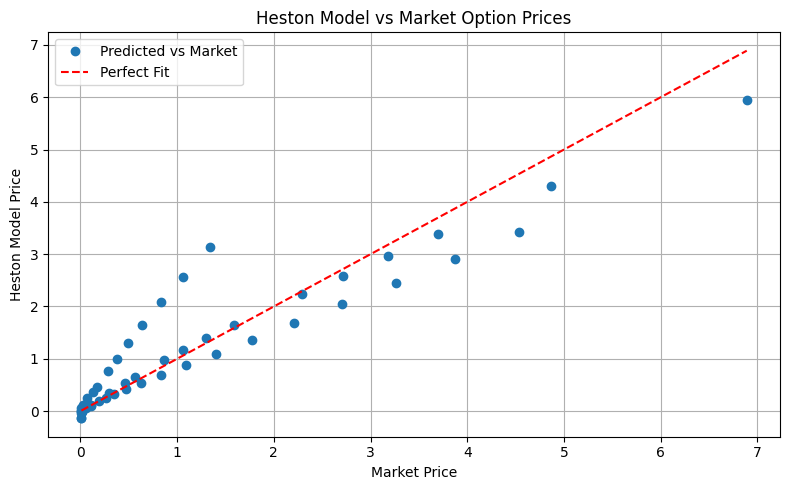

In [1]:
import numpy as np
import pandas as pd
from scipy.integrate import quad
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Characteristic function for Heston model
def heston_cf(phi, S, K, T, r, kappa, theta, sigma, rho, v0, Pnum):
    i = complex(0, 1)
    x = np.log(S)
    if Pnum == 1:
        u, b = 0.5, kappa - rho * sigma
    else:
        u, b = -0.5, kappa
    a = kappa * theta
    d = np.sqrt((rho * sigma * i * phi - b)**2 - sigma**2 * (2 * u * i * phi - phi**2))
    g = (b - rho * sigma * i * phi + d) / (b - rho * sigma * i * phi - d)
    C = r * i * phi * T + a / sigma**2 * ((b - rho * sigma * i * phi + d) * T - 2 * np.log((1 - g * np.exp(d * T)) / (1 - g)))
    D = (b - rho * sigma * i * phi + d) / sigma**2 * ((1 - np.exp(d * T)) / (1 - g * np.exp(d * T)))
    return np.exp(C + D * v0 + i * phi * x)

# Heston price using semi-analytical approach
def heston_price(S, K, T, r, kappa, theta, sigma, rho, v0):
    integrand = lambda phi: np.real(np.exp(-1j * phi * np.log(K)) * heston_cf(phi, S, K, T, r, kappa, theta, sigma, rho, v0, 1) / (1j * phi))
    P1 = 0.5 + (1 / np.pi) * quad(integrand, 0, 100)[0]

    integrand = lambda phi: np.real(np.exp(-1j * phi * np.log(K)) * heston_cf(phi, S, K, T, r, kappa, theta, sigma, rho, v0, 2) / (1j * phi))
    P2 = 0.5 + (1 / np.pi) * quad(integrand, 0, 100)[0]

    return S * P1 - K * np.exp(-r * T) * P2

# Objective function for optimization
def objective(params, data):
    kappa, theta, sigma, rho, v0 = params
    error = 0
    for _, row in data.iterrows():
        try:
            model_price = heston_price(row['S'], row['K'], row['T'], row['r'], kappa, theta, sigma, rho, v0)
            error += (model_price - row['market_price'])**2
        except:
            continue
    return error / len(data)

# Load data
df = pd.read_csv('/content/option_SPY_dataset_combined.csv')

# Preprocess
df = df[['underlying', 'strike', 'daysToExpiration', 'mark']].dropna()
df = df[df['daysToExpiration'] > 1].head(50)
df.columns = ['S', 'K', 'T_days', 'market_price']
df['T'] = df['T_days'] / 365
df['r'] = 0.05  # Assume 5% risk-free rate

# Calibrate model
initial_guess = [1.0, 0.04, 0.3, -0.5, 0.04]  # [kappa, theta, sigma, rho, v0]
bounds = [(0.01, 5), (0.01, 1), (0.01, 1), (-0.99, 0.99), (0.001, 0.5)]

result = minimize(objective, initial_guess, args=(df,), bounds=bounds, method='L-BFGS-B')
kappa, theta, sigma, rho, v0 = result.x

print(f"Calibrated Parameters:\nκ = {kappa:.4f}, θ = {theta:.4f}, σ = {sigma:.4f}, ρ = {rho:.4f}, v₀ = {v0:.4f}")

# Predict prices
df['model_price'] = df.apply(lambda row: heston_price(row['S'], row['K'], row['T'], row['r'], kappa, theta, sigma, rho, v0), axis=1)

# Plot
plt.figure(figsize=(8,5))
plt.plot(df['market_price'], df['model_price'], 'o', label='Predicted vs Market')
plt.plot([df['market_price'].min(), df['market_price'].max()],
         [df['market_price'].min(), df['market_price'].max()], 'r--', label='Perfect Fit')
plt.xlabel("Market Price")
plt.ylabel("Heston Model Price")
plt.title("Heston Model vs Market Option Prices")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
